# Algoritmo de Deutsch

## Descripción general

El **Algoritmo de Deutsch** es un protocolo cuántico fundamental y uno de los primeros ejemplos que demuestra una "ventaja cuántica".

Su propósito es determinar una propiedad global de una "función oráculo" (o caja negra) `f(x)` que toma un bit de entrada, `x` (0 o 1), y produce un bit de salida, `f(x)`. El algoritmo determina si la función es:

- **Constante:** La salida es la misma para todas las entradas (ej. `f(0) = f(1)`).
- **Balanceada:** La salida es diferente para cada entrada (ej. `f(0) ≠ f(1)`).

### Recursos utilizados
- 2 qubits (q0: qubit de entrada, q1: qubit auxiliar o "ancilla")
- 1 bit clásico (para la medición final)
- 1 consulta al oráculo cuántico (`U_f`)

### Idea principal
Mientras que un computador clásico necesitaría consultar la función *dos veces* (una para `x=0` y otra para `x=1`) para determinar si es constante o balanceada, el algoritmo de Deutsch logra resolver el problema con **una sola consulta** al oráculo cuántico.

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import Aer
from qiskit_ibm_runtime import Sampler

# Cargar credenciales (este paso es opcional, se puede simular)
try:
    service = QiskitRuntimeService()  # usa cuenta previamente guardada
    backend = service.backend("ibm_brisbane") #Utilizamos Brisbane, pero se puede utilizar ibm_torino
    print("Conexión con IBM Quantum Platform exitoso")
except Exception:
    backend = Aer.get_backend("aer_simulator")
    print("Utilizando el simulador de AER")

Conexión con IBM Quantum Platform exitoso


## Procedimiento

El protocolo consta de **cuatro etapas** principales:

1.  **Preparación de los qubits:**
    * Se inicializa el primer qubit (`q0`) en `|0⟩`.
    * Se inicializa el segundo qubit (`q1`) en `|1⟩` (aplicando una compuerta `X`).

2.  **Superposición:**
    * Se aplica una compuerta Hadamard (`H`) a **ambos** qubits para ponerlos en superposición.

3.  **Oráculo:**
    * Se aplica el oráculo cuántico `U_f`, que codifica la función `f(x)`. Existen cuatro posibles oráculos (dos constantes y dos balanceados).

4.  **Medición:**
    * Se aplica una compuerta Hadamard (`H`) *únicamente* al primer qubit (`q0`).
    * Se mide el primer qubit (`q0`) en la base computacional.

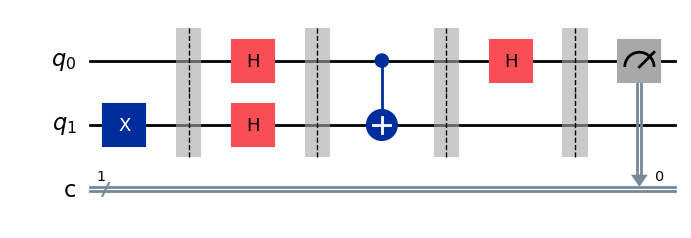

In [4]:
# Definir los registros 
# 2 qubits (q0: entrada, q1: ancilla), 1 bit clásico (para la respuesta)
qc = QuantumCircuit(2, 1)

# Preparación de los qubits 
# q0 ya está en |0>
qc.x(1)          # Inicializamos q1 en |1>
qc.barrier()

# Superposición 
qc.h(0)
qc.h(1)
qc.barrier()

# Oráculo 
# Implementaremos uno de los oráculos.
# Elegiremos un oráculo BALANCEADO: f(x) = x
# Esto se implementa con una compuerta CNOT (CX)
# donde q0 es el control y q1 es el objetivo.

qc.cx(0, 1)

# (Si quisiéramos probar una función CONSTANTE, f(x)=0,
#  simplemente no pondríamos ninguna compuerta aquí).

qc.barrier()

# Medición 
qc.h(0)
qc.barrier()
qc.measure(0, 0) # Medimos el qubit 0 en el bit clásico 0

# Dibujar el circuito 
qc.draw("mpl")

### Explicación del circuito
- **Qubits:** `q0` (entrada) y `q1` (auxiliar/ancilla).
- **Preparación:** `q0` está en `|0⟩` y `q1` se pone en `|1⟩` (estado `|01⟩`).
- **Superposición:** Las compuertas `H` crean el estado `(|0⟩ - |1⟩) / √2` en `q1` (conocido como `|-⟩`) y `(|0⟩ + |1⟩) / √2` en `q0`.
- **Oráculo:** Hemos elegido `qc.cx(0, 1)`. Esta compuerta implementa la función **balanceada** `f(x) = x`. Es nuestra "caja negra".
- **Medición:** La `H` final en `q0` transforma la información de fase (obtenida por el oráculo) de nuevo a la base computacional. La medición de `q0` nos da la respuesta.

Transpilando el circuito para el backend...
Transpilación completada.
Enviando trabajo al Sampler...
Trabajo completado.
Resultados de la medición del qubit 0:


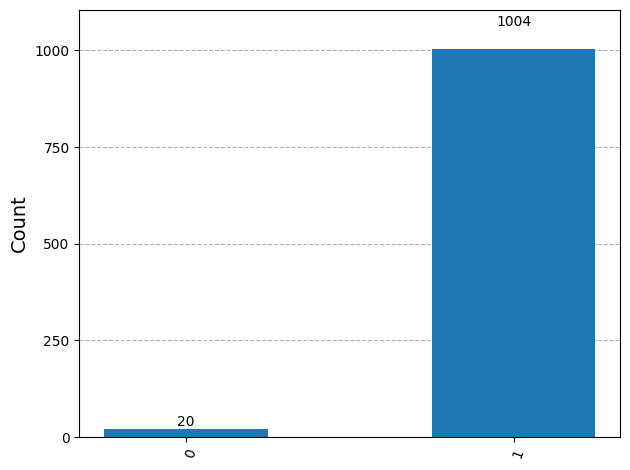

In [5]:
# Ejecución del circuito 

# Transpila tu circuito lógico 'qc' para el 'backend'
print("Transpilando el circuito para el backend...")
tqc = transpile(qc, backend=backend)
print("Transpilación completada.")

# 2. Instancia el Sampler 
sampler = Sampler(mode=backend)
print("Enviando trabajo al Sampler...")

# 3. Ejecuta el .run() con el circuito ya transpilado (tqc) y los shots
job = sampler.run([tqc], shots=1024) 
result = job.result()
print("Trabajo completado.")

# Obtén los resultados del formato V2
# (Usamos .c.get_counts() porque el registro clásico se llama 'c' por defecto)
pub_result = result[0]
counts = pub_result.data.c.get_counts()

# Visualización
print("Resultados de la medición del qubit 0:")
plot_histogram(counts)

### Interpretación de resultados
- El histograma muestra el resultado de la medición del **bit 0** (que corresponde al qubit `q0`).
- **La teoría predice:**
    - Si la función es **Constante**, la medición de `q0` *siempre* será `0`.
    - Si la función es **Balanceada**, la medición de `q0` *siempre* será `1`.
- Dado que implementamos el oráculo para una función **balanceada** (`f(x)=x`), en un simulador ideal, el histograma debería mostrar el 100% de las cuentas en el estado `1`.
- La aparición de cuentas en `0` (si se ejecuta en hardware real) se debe al ruido cuántico, pero la barra del `1` será abrumadoramente dominante.

## Conclusión

El algoritmo de Deutsch demuestra cómo el **paralelismo cuántico** y la **interferencia** permiten que una sola consulta al oráculo `U_f` nos dé información sobre *múltiples* valores de la función `f(x)` simultáneamente.

- Al poner `q0` en superposición, el oráculo actúa sobre `|0⟩` y `|1⟩` al mismo tiempo.
- La compuerta Hadamard final (`H`) hace que los caminos computacionales interfieran:
    - Si la función es constante, interfieren constructivamente hacia el estado `|0⟩`.
    - Si la función es balanceada, interfieren constructivamente hacia el estado `|1⟩`.

Aunque es un problema simple, el algoritmo de Deutsch fue la primera prueba de que un computador cuántico podía resolver un problema más rápido (en número de consultas) que cualquier computador clásico posible.